In [250]:
!nvidia-smi

Sat Jun 15 16:08:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.33                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   67C    P8              12W /  40W |   3746MiB /  4096MiB |     39%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [251]:
!git clone https://github.com/IndoNLP/indonlu.git

fatal: destination path 'indonlu' already exists and is not an empty directory.


# 1. Import Library

In [252]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

# Import required Python package
!pip install pandas

# Install Node.js (because tweet-harvest built using Node.js)
!sudo apt-get update
!sudo apt-get install -y ca-certificates curl gnupg
!sudo mkdir -p /etc/apt/keyrings
!curl -fsSL https://deb.nodesource.com/gpgkey/nodesource-repo.gpg.key | sudo gpg --dearmor -o /etc/apt/keyrings/nodesource.gpg

!NODE_MAJOR=20 && echo "deb [signed-by=/etc/apt/keyrings/nodesource.gpg] https://deb.nodesource.com/node_$NODE_MAJOR.x nodistro main" | sudo tee /etc/apt/sources.list.d/nodesource.list

!sudo apt-get update
!sudo apt-get install nodejs -y

!node -v

'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.
'NODE_MAJOR' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sudo' is not recognized as an internal or external command,
operable program or batch file.


v20.11.0


In [253]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt')
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

#Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sendo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [254]:
# Crawl Data

# twitter_auth_token = '8e0c51ebff4c16ef59890bcf1cc04af4e7e73cbd'
# filename = 'biznet30.csv'
# search_keyword = 'biznet lang:id since:2019-07-01 until:2019-08-31'
# limit = 1000

# !npx --yes tweet-harvest@2.6.1 -o "{filename}" -s "{search_keyword}" -l {limit} --token {twitter_auth_token}

In [255]:
file_path = f"biznet_data.csv"
df = pd.read_csv(file_path, delimiter=",", encoding="utf-8", names=['tweet', 'sentiment'])
display(df)
num_rows = len(df)
print(f"The number of rows in the DataFrame is: {num_rows}")

,tweet,sentiment
0,hari hari biznet kyk gini gimana mau stream ba...,negative
1,sebenernya bagus biznet... kalau gak gangguan ...,neutral
2,Makasih yang udah dateng &amp; maaf awal2 agak...,negative
3,@ibnux Gak cuman IndiHome ternyata XL home sam...,negative
4,pasti pengguna biznet soalnya sama https://t.c...,neutral
...,...,...
3046,Biznet Raih Penghargaan Indonesia Most Innovat...,positive
3047,ViidiaVivi Hi malam. Stlh kami cek ID pelangga...,neutral
3048,Biznet terus menggiatkan program Biznet Bali B...,positive
3049,Biznet Akan Perluas Data Center pada 2020 http...,positive


The number of rows in the DataFrame is: 3051


# 2. Exploratory Data Analysis

In [256]:
df_path = 'biznet_data.csv'
# stopword_path = 'stopword.txt'
kamus_alay_path = 'kamus_alay.csv'

In [257]:
# Import data
df = pd.read_csv(file_path, delimiter=",", encoding="utf-8", names=['tweet', 'sentiment'])
df.sample(5)

,tweet,sentiment
632,biznet kamu dah sebulan ya tiap hari bermasala...,negative
188,Biznet knpp muter2 trs si,negative
965,Gerr abiss Tinggal biznet nih semoga ada disko...,positive
1271,Lah biznet sudah ada di samarinda toh. Gak ada...,neutral
1198,Masak sih enggak ada? Malahan Biznet / Melsa /...,neutral


In [258]:
print(f'shape: {df.shape}')

shape: (3051, 2)


In [259]:
print(df.head())

                                               tweet  sentiment
0  hari hari biznet kyk gini gimana mau stream ba...   negative
1  sebenernya bagus biznet... kalau gak gangguan ...    neutral
2  Makasih yang udah dateng &amp; maaf awal2 agak...   negative
3  @ibnux Gak cuman IndiHome ternyata XL home sam...   negative
4  pasti pengguna biznet soalnya sama https://t.c...    neutral


In [260]:
df['sentiment'] = df['sentiment'].str.strip()

In [261]:
# Print unique values in the sentiment column after stripping whitespace
print("Unique values in the sentiment column after stripping whitespace:", df['sentiment'].unique())

# Define the mapping from label to string
LABEL2INDEX = {
    'positive': 'positive',
    'neutral': 'neutral',
    'negative': 'negative'
}

# Check for any unmapped labels
nan_rows = df[df['sentiment'].isna()]
print("Rows with undefined labels:", nan_rows)

# Ensure there are no NaN values after mapping
assert df['sentiment'].isnull().sum() == 0, "Ada label yang tidak terdefinisi dalam LABEL2INDEX"

print("Unique values in the sentiment column after mapping:", df['sentiment'].unique())

Unique values in the sentiment column after stripping whitespace: ['negative' 'neutral' 'positive']
Rows with undefined labels: Empty DataFrame
Columns: [tweet, sentiment]
Index: []
Unique values in the sentiment column after mapping: ['negative' 'neutral' 'positive']


## Proporsi Variabel Target

In [262]:
df['sentiment'].value_counts()

sentiment
negative    1442
neutral      949
positive     660
Name: count, dtype: int64

In [263]:
print(df['sentiment'].unique())

['negative' 'neutral' 'positive']


In [264]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%',
           startangle = angle, pctdistance=0.8, explode = explode,
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')
    plt.tight_layout()

In [265]:
# Plot arguments
sizes = df.sentiment.value_counts()
labels = ['Sentimen Negatif', 'Sentimen Netral', 'Sentimen Positif']
colors = ['lightcoral', 'lightskyblue', 'lightgreen']
explode = (0,0,0)

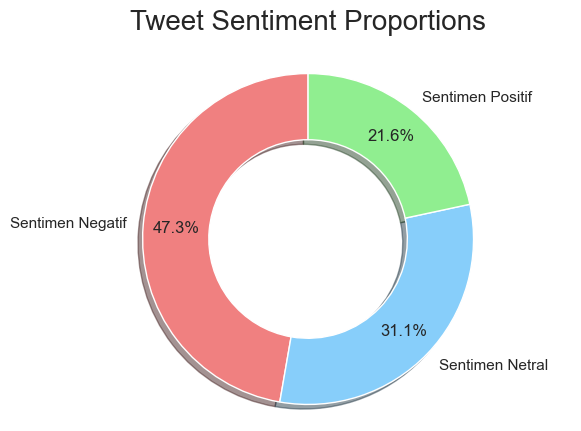

In [266]:
# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Tweet Sentiment Proportions')

plt.show()

# 3. PreProcessing

## Preprocessing Tahap 1

In [267]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(text):
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long
      text = text.replace(char,character[i])
      charac_long -= 1
  return text

In [268]:
def clean_tweet(text):
  # ubah text menjadi huruf kecil
  text = text.lower()
  # ubah enter menjadi spasi
  text = re.sub(r'\n', ' ', text)
  # hapus emoji
  text = emoji.demojize(text)
  text = re.sub(':[A-Za-z_-]+:', ' ', text) # delete emoji
  # hapus emoticon
  text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)
  # hapus link
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)
  # hapus usename
  text = re.sub(r"@[^\s]+[\s]?", ' ', text)
  # hapus hashtag
  text = re.sub(r'#(\S+)', r'\1', text)
  # hapus angka dan beberapa simbol
  text = re.sub('[^a-zA-Z,.?!]+',' ',text)
  # hapus karakter berulang
  text = repeatcharClean(text)
  # clear spasi
  text = re.sub('[ ]+',' ',text)
  return text

In [269]:
def preprocess_v1(df):
  df_pp = df.copy()
  df_pp['tweet'] = df_pp['tweet'].map(clean_tweet)

  # delete empty row
  df_pp.loc[:, 'tweet'] = df_pp['tweet'].replace('', np.nan)
  df_pp.loc[:, 'tweet'] = df_pp['tweet'].replace(' ', np.nan)
  df_pp.dropna(subset=['tweet'], inplace=True)
  return df_pp

In [270]:
df_v1 = preprocess_v1(df)

In [271]:
# export to tsv
df_v1.to_csv('biznet_data_v1.csv', header=None, index=False)

## Preprocessing Tahap 2

In [272]:
# additional_stop = []

# # default stopword
# default_stop = pd.read_csv(stopword_path, header=None, names=['stopwords'])
# default_stop = default_stop['stopwords'].tolist()

# list_stopwords = default_stop + additional_stop

In [273]:
kamus_alay = pd.read_csv(kamus_alay_path)

normalize_word_dict = {}
for index, row in kamus_alay.iterrows():
    if row[0] not in normalize_word_dict:
        normalize_word_dict[row[0]] = row[1]

C:\Users\sendo\AppData\Local\Temp\ipykernel_14684\1539115820.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalize_word_dict:
C:\Users\sendo\AppData\Local\Temp\ipykernel_14684\1539115820.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalize_word_dict[row[0]] = row[1]


In [274]:
def normalize_tweet(text):
  # tokenize
  list_text = word_tokenize(text)
  # ubah bahasa alay
  list_text = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_text]
  # stemming
  # factory = StemmerFactory()
  # stemmer = factory.create_stemmer()
  # list_text = [stemmer.stem(word) for word in list_text]
  # hapus kata yang termasuk stopword
  # list_text = [word for word in list_text if word not in list_stopwords]
  # gabung kembali kalimat
  text = " ".join(list_text)
  return text

In [275]:
def preprocess_v2(df):
  df_pp = df.copy()
  df_pp['tweet'] = df_pp['tweet'].map(normalize_tweet)

  # delete empty row
  df_pp.loc[:, 'tweet'] = df_pp['tweet'].replace('', np.nan)
  df_pp.loc[:, 'tweet'] = df_pp['tweet'].replace(' ', np.nan)
  df_pp.dropna(subset=['tweet'], inplace=True)
  return df_pp

In [276]:
df_v2 = preprocess_v2(df_v1)

In [277]:
# export to tsv
df_v2.to_csv('biznet_data_v2.csv', header=None, index=False)

In [278]:
# Data Augmentation
from nlpaug.augmenter.word import SynonymAug

aug = SynonymAug(aug_src='wordnet')

def augment_text(text, augmenter):
    augmented_text = augmenter.augment(text)
    return augmented_text

df_v2['tweet_aug'] = df_v2['tweet'].apply(lambda x: augment_text(x, aug))
df_v2_augmented = pd.concat([df_v2, df_v2[['tweet_aug', 'sentiment']].rename(columns={'tweet_aug': 'tweet'})])
df_v2_augmented.drop_duplicates(subset=['tweet'], inplace=True)
df_v2_augmented = df_v2_augmented[['tweet', 'sentiment' ]]
# Ekspor data yang telah diproses dan diaugmentasi
df_v2_augmented.to_csv('biznet_data_v2_augmented.csv', header=None, index=False)
# Pastikan semua nilai dalam kolom 'tweet' adalah string
df_v2_augmented['tweet'] = df_v2_augmented['tweet'].astype(str)

In [279]:
def make_corpus(column):

    corpus_list = []

    for text in column:
        cleaned_list = text.split(' ')
        corpus_list.extend(cleaned_list)

    # transform list of words into 1 body of text
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+',' ',corpus) # replace double whitespace with one

    return corpus

In [280]:
corpus = make_corpus(df_v2_augmented['tweet'])

In [281]:
# counting unique words
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 10511


In [282]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples

    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})

    return df

In [283]:
corpus_freq = word_freq(corpus, top=20)

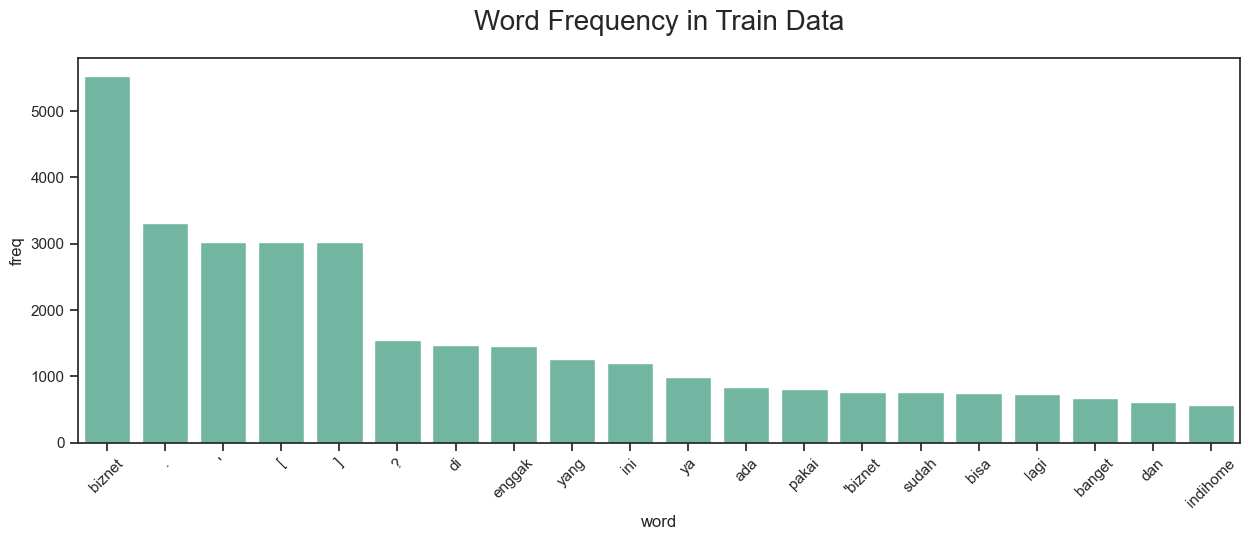

In [284]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

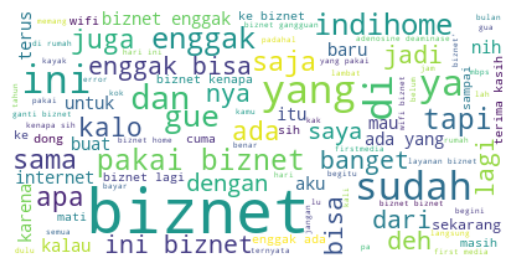

In [285]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 4. Splitting

In [286]:
# train val split
train_set, val_set = train_test_split(df_v2_augmented, test_size=0.3, stratify=df_v2_augmented['sentiment'], random_state=1)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set['sentiment'], random_state=1)

In [287]:
print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

Train shape: (4211, 2)
Val shape: (1209, 2)
Test shape: (596, 2)


In [288]:
# export to tsv
train_set.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('test_set.tsv', sep='\t', header=None, index=False)

In [289]:
train_set['sentiment'].value_counts()

sentiment
negative    1999
neutral     1314
positive     898
Name: count, dtype: int64

In [290]:
val_set['sentiment'].value_counts()

sentiment
negative    574
neutral     377
positive    258
Name: count, dtype: int64

In [291]:
test_set['sentiment'].value_counts()

sentiment
negative    283
neutral     186
positive    127
Name: count, dtype: int64

# 5. Modeling

## a. Finetuning IndoBERT

In [292]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [293]:
# Set random seed
set_seed(27)

## b. Load Model

In [294]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p1',
    config=config,
    ignore_mismatched_sizes=True
)

c:\Users\sendo\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [295]:
# Struktur model
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [296]:
count_param(model)

124443651

## c. Prepare Dataset

In [297]:
train_dataset_path = 'train_set.tsv'
valid_dataset_path = 'val_set.tsv'
test_dataset_path = 'test_set.tsv'

In [298]:
# fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=8, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=8, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=8, shuffle=False)

In [299]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) #word to index
print(i2w) #index to word

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


## d. Uji coba pre-trained model

In [300]:
text = 'wifi biznet lambat sekali'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: wifi biznet lambat sekali | Label : neutral (41.313%)


In [301]:
text = 'wifi biznet stabil atau tidak?'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: wifi biznet stabil atau tidak? | Label : neutral (40.774%)


In [302]:
text = 'wifi biznet cepat dan lancar'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: wifi biznet cepat dan lancar | Label : neutral (40.166%)


In [303]:
# Evaluate model before fine-tuning
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp_before, list_label_before = [], []

pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device=model.device)
    list_hyp_before += batch_hyp
    list_label_before += batch_label

metrics_before = document_sentiment_metrics_fn(list_hyp_before, list_label_before)
print("Before Fine-tuning: ", metrics_to_string(metrics_before))

100%|██████████| 38/38 [02:03<00:00,  3.26s/it]

Before Fine-tuning:  ACC:0.31 F1:0.18 REC:0.33 PRE:0.28


## e. Fine Tuning & Prediksi Evaluation

In [304]:
# Tentukan optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
model = model.cuda()

### Training

In [305]:
# Train
# Tambahkan early stopping dan dropout
from torch.nn import Dropout

dropout = Dropout(p=0.4)  # Adjust the dropout rate
n_epochs = 5  # Adjusted number of epochs
history = defaultdict(list)
best_val_acc = 0
patience = 2
best_val_loss = float('inf')
patience_counter = 0
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # save train acc for learning curve
    history['train_acc'].append(metrics['ACC'])

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

    # save validation acc for learning curve
    history['val_acc'].append(metrics['ACC'])
    
    # Early stopping
    # if metrics['ACC'] > best_val_acc:
    #     best_val_acc = metrics['ACC']
    #     patience_counter = 0
    # else:
    #     patience_counter += 1

    # if patience_counter >= patience:
    #     print("Early stopping activated")
    #     break
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        break

  0%|          | 0/132 [00:00<?, ?it/s]

(Epoch 1) TRAIN LOSS:0.5799 LR:0.00005000: 100%|██████████| 132/132 [10:26<00:00,  4.74s/it]


(Epoch 1) TRAIN LOSS:0.5799 ACC:0.76 F1:0.74 REC:0.73 PRE:0.75 LR:0.00005000


VALID LOSS:0.5167 ACC:0.80 F1:0.79 REC:0.79 PRE:0.80: 100%|██████████| 38/38 [01:24<00:00,  2.23s/it]


(Epoch 1) VALID LOSS:0.5167 ACC:0.80 F1:0.79 REC:0.79 PRE:0.80


(Epoch 2) TRAIN LOSS:0.2622 LR:0.00005000: 100%|██████████| 132/132 [14:26<00:00,  6.56s/it]


(Epoch 2) TRAIN LOSS:0.2622 ACC:0.91 F1:0.90 REC:0.90 PRE:0.90 LR:0.00005000


VALID LOSS:0.4256 ACC:0.86 F1:0.85 REC:0.83 PRE:0.87: 100%|██████████| 38/38 [01:34<00:00,  2.48s/it]


(Epoch 2) VALID LOSS:0.4256 ACC:0.86 F1:0.85 REC:0.83 PRE:0.87


(Epoch 3) TRAIN LOSS:0.1099 LR:0.00005000: 100%|██████████| 132/132 [11:46<00:00,  5.35s/it]


(Epoch 3) TRAIN LOSS:0.1099 ACC:0.96 F1:0.96 REC:0.96 PRE:0.96 LR:0.00005000


VALID LOSS:0.4101 ACC:0.89 F1:0.88 REC:0.88 PRE:0.89: 100%|██████████| 38/38 [01:14<00:00,  1.97s/it]


(Epoch 3) VALID LOSS:0.4101 ACC:0.89 F1:0.88 REC:0.88 PRE:0.89


(Epoch 4) TRAIN LOSS:0.0729 LR:0.00005000: 100%|██████████| 132/132 [12:02<00:00,  5.47s/it]


(Epoch 4) TRAIN LOSS:0.0729 ACC:0.98 F1:0.98 REC:0.98 PRE:0.98 LR:0.00005000


VALID LOSS:0.4127 ACC:0.89 F1:0.88 REC:0.88 PRE:0.88: 100%|██████████| 38/38 [01:49<00:00,  2.87s/it]


(Epoch 4) VALID LOSS:0.4127 ACC:0.89 F1:0.88 REC:0.88 PRE:0.88


(Epoch 5) TRAIN LOSS:0.0575 LR:0.00005000: 100%|██████████| 132/132 [12:45<00:00,  5.80s/it]


(Epoch 5) TRAIN LOSS:0.0575 ACC:0.98 F1:0.98 REC:0.98 PRE:0.98 LR:0.00005000


VALID LOSS:0.5516 ACC:0.89 F1:0.88 REC:0.87 PRE:0.89: 100%|██████████| 38/38 [01:34<00:00,  2.49s/it]

(Epoch 5) VALID LOSS:0.5516 ACC:0.89 F1:0.88 REC:0.87 PRE:0.89
Early stopping on epoch 5


In [ ]:
# Train
# Tambahkan early stopping dan dropout
from torch.nn import Dropout

dropout = Dropout(p=0.4)  # Adjust the dropout rate
n_epochs = 5  # Adjusted number of epochs
history = defaultdict(list)
best_val_acc = 0
patience = 2
best_val_loss = float('inf')
patience_counter = 0
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # save train acc for learning curve
    history['train_acc'].append(metrics['ACC'])

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

    # save validation acc for learning curve
    history['val_acc'].append(metrics['ACC'])
    
    # Early stopping
    # if metrics['ACC'] > best_val_acc:
    #     best_val_acc = metrics['ACC']
    #     patience_counter = 0
    # else:
    #     patience_counter += 1

    # if patience_counter >= patience:
    #     print("Early stopping activated")
    #     break
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        break

  0%|          | 0/132 [00:00<?, ?it/s]

(Epoch 1) TRAIN LOSS:0.5799 LR:0.00005000: 100%|██████████| 132/132 [10:26<00:00,  4.74s/it]


(Epoch 1) TRAIN LOSS:0.5799 ACC:0.76 F1:0.74 REC:0.73 PRE:0.75 LR:0.00005000


VALID LOSS:0.5167 ACC:0.80 F1:0.79 REC:0.79 PRE:0.80: 100%|██████████| 38/38 [01:24<00:00,  2.23s/it]


(Epoch 1) VALID LOSS:0.5167 ACC:0.80 F1:0.79 REC:0.79 PRE:0.80


(Epoch 2) TRAIN LOSS:0.2622 LR:0.00005000: 100%|██████████| 132/132 [14:26<00:00,  6.56s/it]


(Epoch 2) TRAIN LOSS:0.2622 ACC:0.91 F1:0.90 REC:0.90 PRE:0.90 LR:0.00005000


VALID LOSS:0.4256 ACC:0.86 F1:0.85 REC:0.83 PRE:0.87: 100%|██████████| 38/38 [01:34<00:00,  2.48s/it]


(Epoch 2) VALID LOSS:0.4256 ACC:0.86 F1:0.85 REC:0.83 PRE:0.87


(Epoch 3) TRAIN LOSS:0.1099 LR:0.00005000: 100%|██████████| 132/132 [11:46<00:00,  5.35s/it]


(Epoch 3) TRAIN LOSS:0.1099 ACC:0.96 F1:0.96 REC:0.96 PRE:0.96 LR:0.00005000


VALID LOSS:0.4101 ACC:0.89 F1:0.88 REC:0.88 PRE:0.89: 100%|██████████| 38/38 [01:14<00:00,  1.97s/it]


(Epoch 3) VALID LOSS:0.4101 ACC:0.89 F1:0.88 REC:0.88 PRE:0.89


(Epoch 4) TRAIN LOSS:0.0729 LR:0.00005000: 100%|██████████| 132/132 [12:02<00:00,  5.47s/it]


(Epoch 4) TRAIN LOSS:0.0729 ACC:0.98 F1:0.98 REC:0.98 PRE:0.98 LR:0.00005000


VALID LOSS:0.4127 ACC:0.89 F1:0.88 REC:0.88 PRE:0.88: 100%|██████████| 38/38 [01:49<00:00,  2.87s/it]


(Epoch 4) VALID LOSS:0.4127 ACC:0.89 F1:0.88 REC:0.88 PRE:0.88


(Epoch 5) TRAIN LOSS:0.0575 LR:0.00005000: 100%|██████████| 132/132 [12:45<00:00,  5.80s/it]


(Epoch 5) TRAIN LOSS:0.0575 ACC:0.98 F1:0.98 REC:0.98 PRE:0.98 LR:0.00005000


VALID LOSS:0.5516 ACC:0.89 F1:0.88 REC:0.87 PRE:0.89: 100%|██████████| 38/38 [01:34<00:00,  2.49s/it]

(Epoch 5) VALID LOSS:0.5516 ACC:0.89 F1:0.88 REC:0.87 PRE:0.89
Early stopping on epoch 5


### Learning Curve

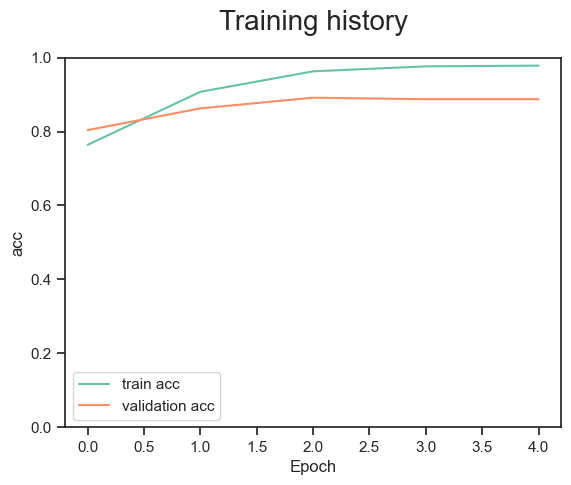

In [306]:
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [307]:
# Simpan Hasil Prediksi Validation Set
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['tweet', 'sentiment'])
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result.csv', index=False)

## f. Prediksi Test Set

In [308]:
# Prediksi test set
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

100%|██████████| 19/19 [01:00<00:00,  3.19s/it]


In [309]:
# Simpan prediksi test set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['tweet', 'sentiment'])
test_df['pred'] = pred
test_df.head()
test_df.to_csv('test result.csv', index=False)

## e. Test fine-tuned model on sample sentences

In [310]:
text = 'wifi biznet lambat sekali'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: wifi biznet lambat sekali | Label : negative (99.854%)


In [311]:
text = 'wifi biznet stabil atau tidak?'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: wifi biznet stabil atau tidak? | Label : neutral (93.442%)


In [312]:
text = 'wifi biznet cepat dan lancar'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: wifi biznet cepat dan lancar | Label : positive (99.851%)


# 6. Evaluasi

In [313]:
val_real = val_df.sentiment
val_pred = val_df.pred

test_real = test_df.sentiment
test_pred = test_df.pred

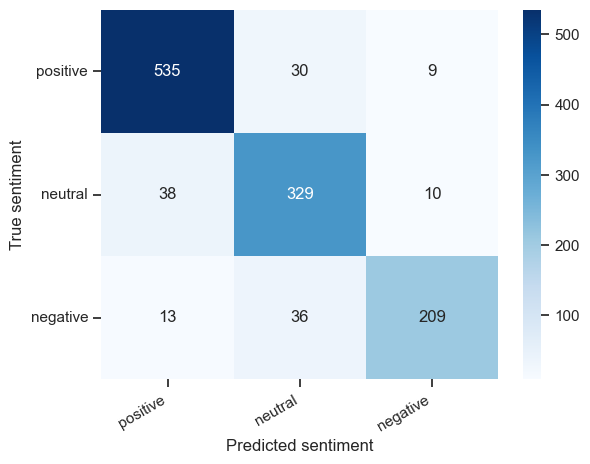

In [314]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(val_real, val_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [315]:
print(classification_report(val_real, val_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.91      0.93      0.92       574
     neutral       0.83      0.87      0.85       377
    negative       0.92      0.81      0.86       258

    accuracy                           0.89      1209
   macro avg       0.89      0.87      0.88      1209
weighted avg       0.89      0.89      0.89      1209



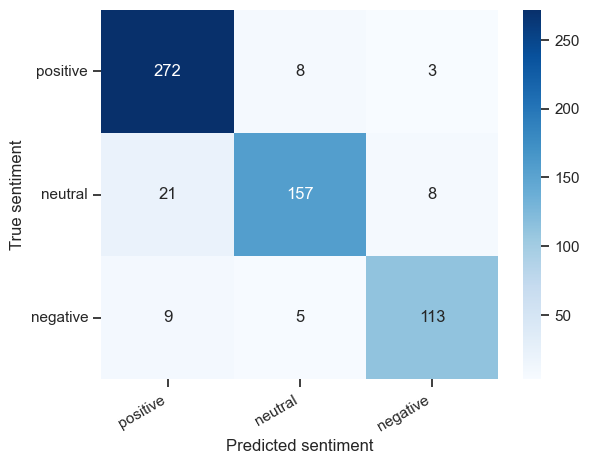

In [316]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(test_real, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [317]:
print(classification_report(test_real, test_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.90      0.96      0.93       283
     neutral       0.92      0.84      0.88       186
    negative       0.91      0.89      0.90       127

    accuracy                           0.91       596
   macro avg       0.91      0.90      0.90       596
weighted avg       0.91      0.91      0.91       596

